In [1]:

import numpy as np
import math
import matplotlib.pyplot as plt
import random
import timeit
import scipy.fftpack
import scipy.io as sio
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import interpolate
from PIL import Image
from skimage import filters
import scipy.ndimage as ndimage
import random
#import imreg_dft as ird
from dipy.data import get_fnames
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools
from skimage.transform import resize
from scipy.ndimage import affine_transform, rotate
import scipy.optimize as optimize
from skimage import exposure

/opt/anaconda3/envs/transposition-env/lib/python3.7/site-packages/dipy/viz/__init__.py:22: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  "You do not have FURY installed. "


# Generate Blank Staff

In [3]:
def load(name):
    music = np.asarray(Image.open(name))
    red = music[..., 0]
    green = music[..., 1]
    blue = music[..., 2]

    music = 0.21 * red + 0.72 * green + 0.07 * blue
    
    thresh = filters.threshold_otsu(music)+60
    music[music > thresh]=255
    music[music <= thresh]=0
    
    music=music.astype(np.uint8)
    return music

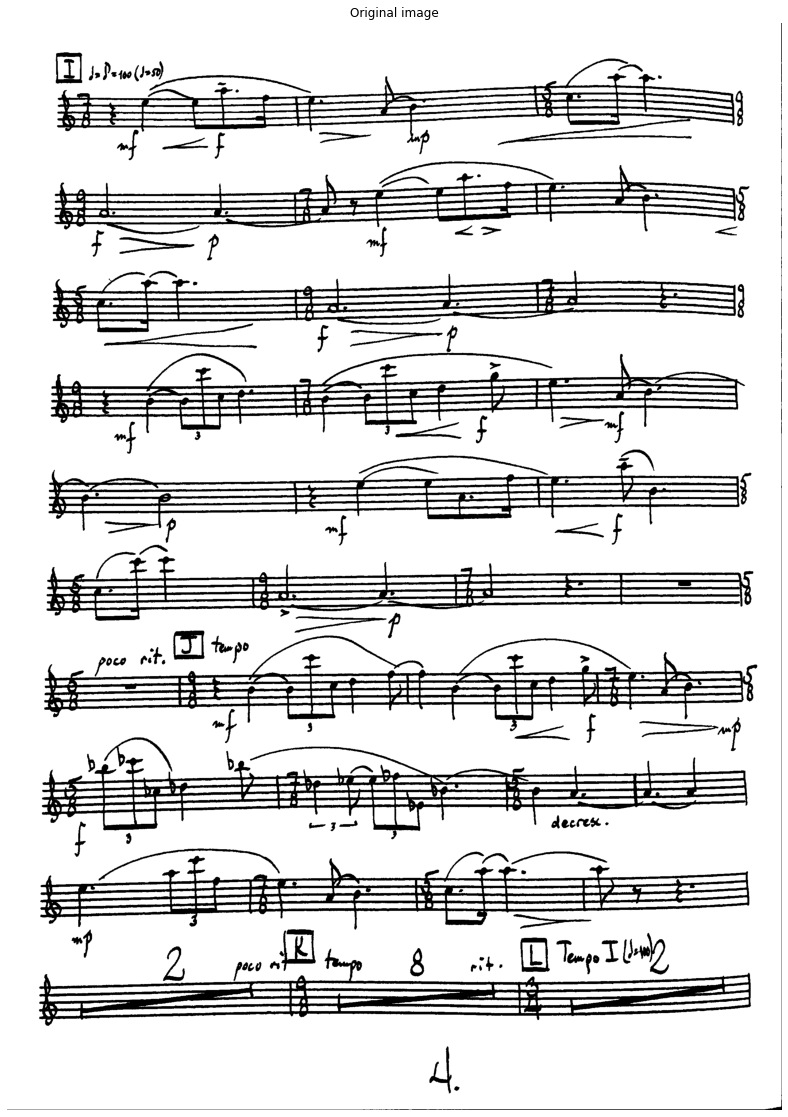

In [5]:
music = load("./data/nc4.jpg")
# plot original image
plt.figure(figsize=(30, 20))
plt.imshow(music, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Original image')

plt.show()

Find connected Components

In [17]:
labeled_music, label_num = ndimage.measurements.label(~music)

In [18]:
label_num

171

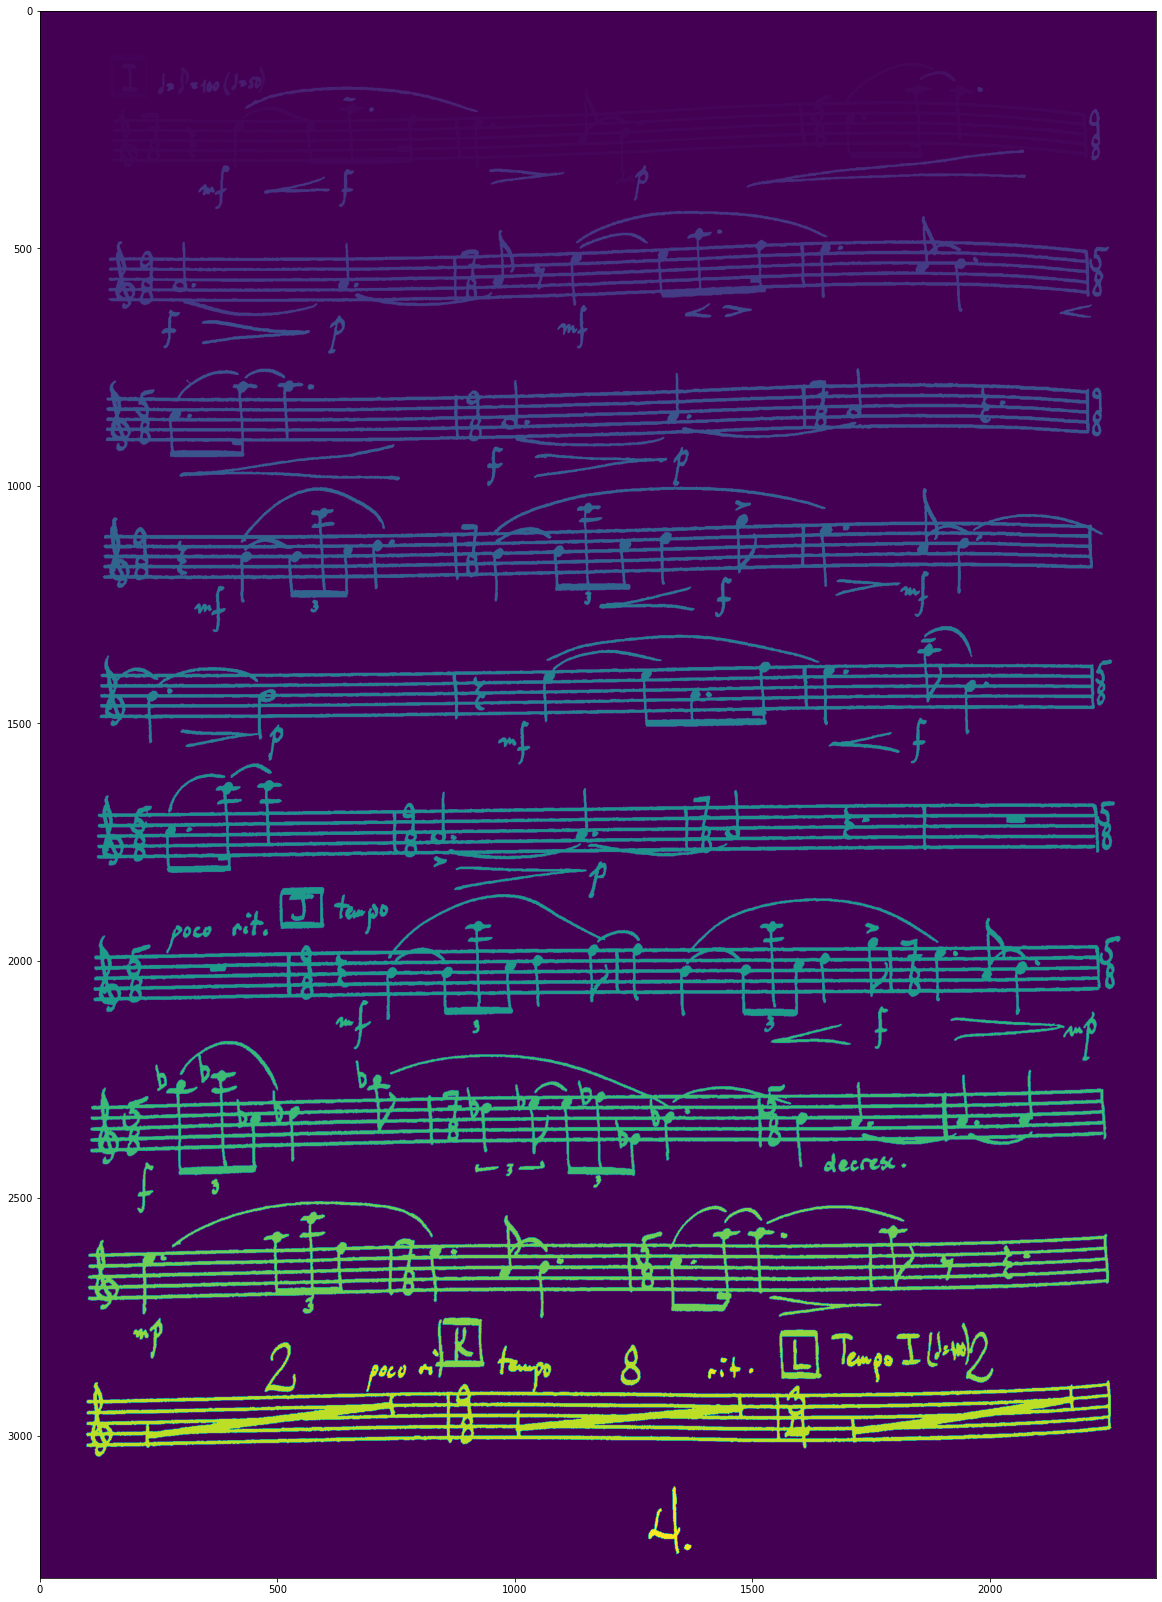

In [19]:
plt.figure(figsize=(20,30))
plt.imshow(labeled_music)

Find size of each connected component

In [85]:
sizearr = np.zeros(label_num+1)
for i in range(1, label_num):
    sizearr[i]=np.count_nonzero(labeled_music == i)
    


In [86]:
cc_thresh = filters.threshold_otsu(sizearr)

In [87]:
cc_thresh

7874.58984375

In [88]:
#do not save first iteration


component_dict = {}
maxsize = labeled_music.shape[0]*labeled_music.shape[1]
while maxsize >= cc_thresh:
    maxsize =np.max(sizearr)
    max_index =np.argwhere(sizearr == maxsize)[0][0]
    print(max_index)
    component_dict[max_index]=np.max(sizearr)
    sizearr[max_index]=0
    
    
    

117
94
154
56
134
88
45
76
30
3
1


In [89]:
component_dict

{117: 115194.0,
 94: 111688.0,
 154: 108715.0,
 56: 105128.0,
 134: 104910.0,
 88: 94023.0,
 45: 89577.0,
 76: 88912.0,
 30: 87860.0,
 3: 81913.0,
 1: 7824.0}

In [90]:
ccs = ndimage.find_objects(labeled_music)

In [92]:
ccs

[(slice(0, 3300, None), slice(0, 2350, None)),
 (slice(92, 187, None), slice(148, 228, None)),
 (slice(111, 367, None), slice(152, 2206, None)),
 (slice(112, 172, None), slice(172, 206, None)),
 (slice(119, 174, None), slice(460, 474, None)),
 (slice(120, 176, None), slice(291, 314, None)),
 (slice(128, 151, None), slice(1852, 1928, None)),
 (slice(131, 180, None), slice(386, 400, None)),
 (slice(133, 177, None), slice(248, 263, None)),
 (slice(133, 169, None), slice(403, 416, None)),
 (slice(140, 166, None), slice(438, 467, None)),
 (slice(146, 174, None), slice(338, 350, None)),
 (slice(147, 162, None), slice(418, 436, None)),
 (slice(149, 173, None), slice(350, 378, None)),
 (slice(152, 167, None), slice(316, 333, None)),
 (slice(154, 171, None), slice(266, 282, None)),
 (slice(161, 215, None), slice(431, 922, None)),
 (slice(162, 172, None), slice(1974, 1985, None)),
 (slice(183, 192, None), slice(639, 664, None)),
 (slice(204, 214, None), slice(693, 703, None)),
 (slice(208, 316, 

117
94
154
56
134
88
45
76
30
3
1


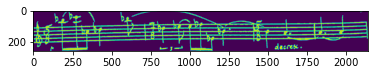

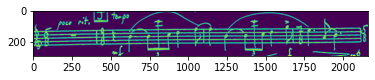

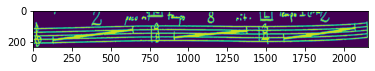

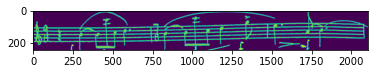

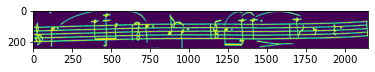

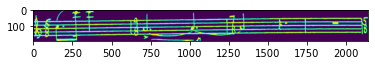

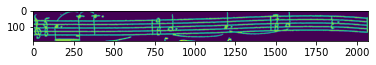

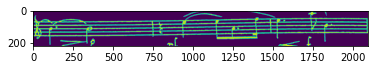

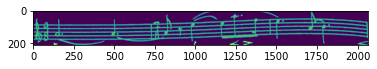

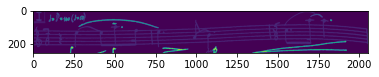

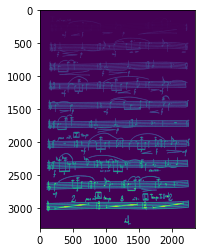

In [133]:
for cc in component_dict.keys():

        plt.figure()
        print(cc)
        plt.imshow(labeled_music[ccs[cc-1]])

In [135]:
segment = labeled_music[ccs[116]]

"\nimgrecon = np.real(scipy.fftpack.ifft2(scipy.fftpack.fftshift((imgX * gaus2d))))\n\nplt.subplot2grid((2, 2), (0, 1))\nplt.imshow(imgrecon, cmap=plt.cm.gray)\nplt.axis('off')\nplt.title('Filtered image')\n"

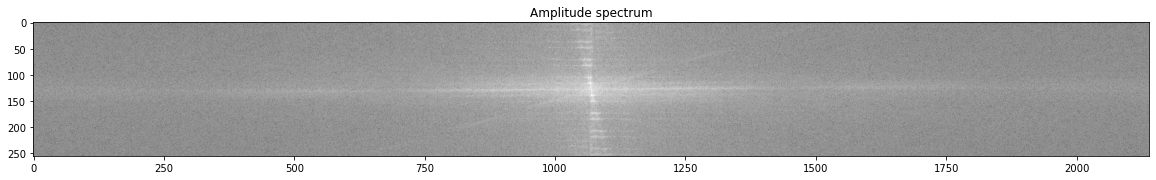

In [137]:

# and its power spectrum
imgX  = scipy.fftpack.fftshift(scipy.fftpack.fft2(segment))
powr2 = np.log(np.abs(imgX))

plt.figure(figsize=(20, 10))
plt.imshow(powr2, cmap=plt.cm.gray)
plt.clim([0, 15])

plt.title('Amplitude spectrum')
'''
imgrecon = np.real(scipy.fftpack.ifft2(scipy.fftpack.fftshift((imgX * gaus2d))))

plt.subplot2grid((2, 2), (0, 1))
plt.imshow(imgrecon, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Filtered image')
'''
#plt.show()

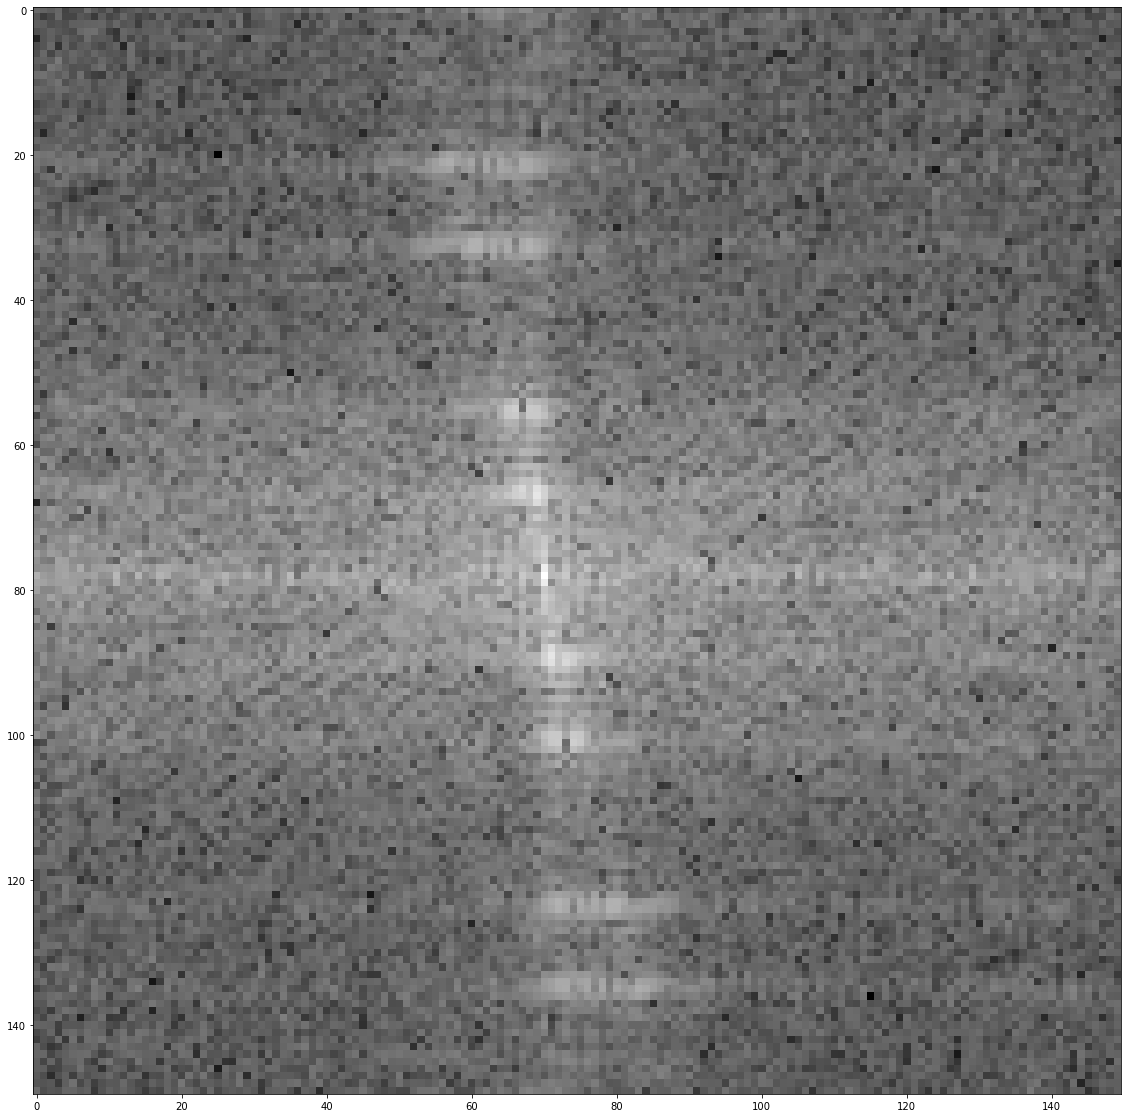

In [204]:
seg=imgX.copy()
seg0 = seg[50:200, 1000:1150]

plt.figure(figsize=(20,20))
plt.imshow(np.log(np.abs(seg0)), cmap='gray')

In [ ]:
seg_real = ndimage.median_filter(np.log(np.abs(seg0)), size=20)

In [192]:
thresh = filters.threshold_otsu(seg_real)
mask = seg_real > thresh
thresh2 = filters.threshold_otsu(seg_real[mask])


In [190]:
seg0[0:seg0.shape[0]-1, 0:60]=0
seg0[0:seg0.shape[0]-1, 100: seg0.shape[1]]=0

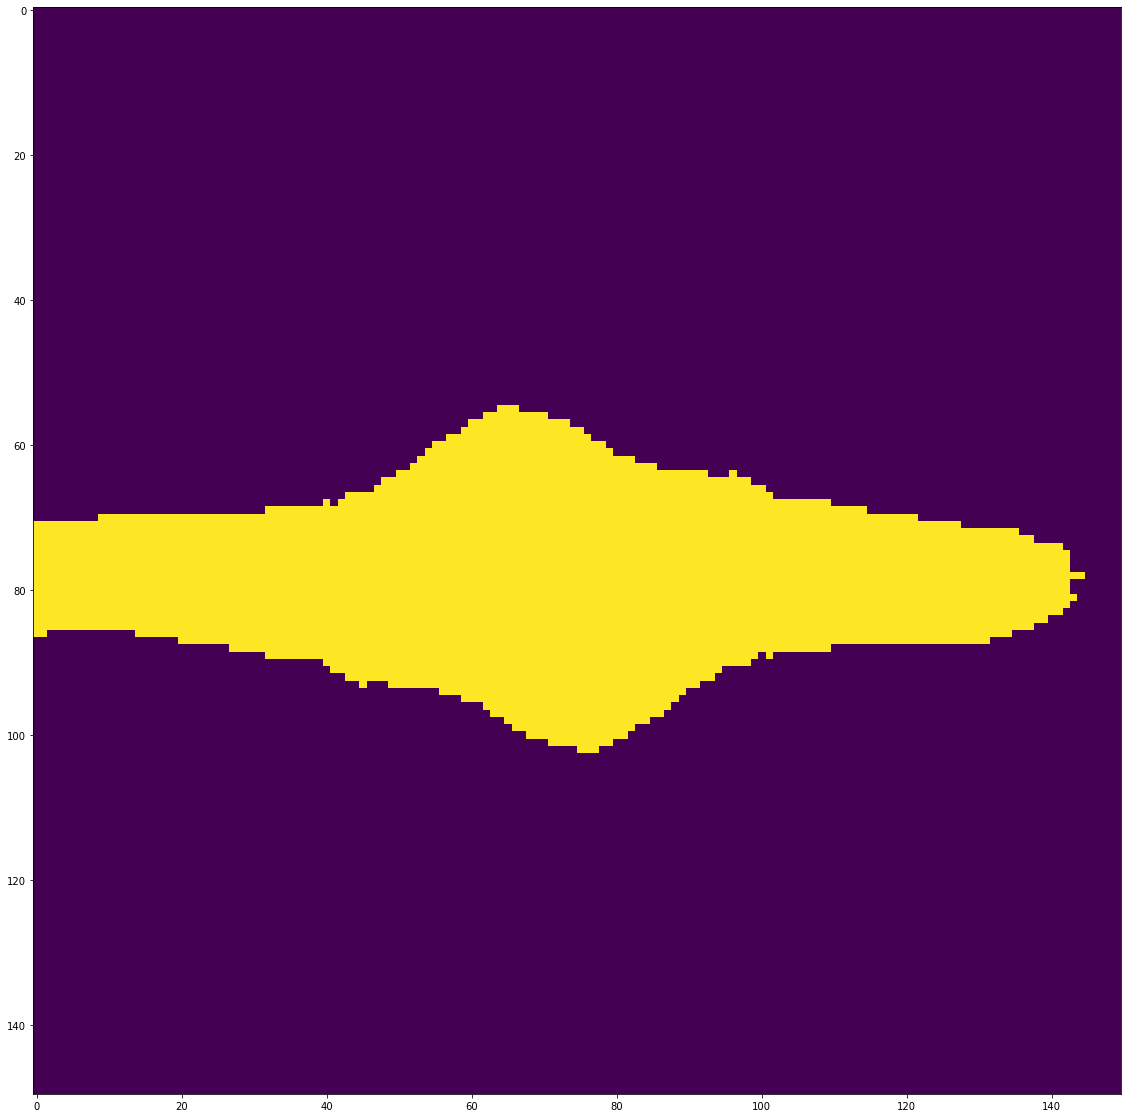

In [193]:
plt.figure(figsize=(20,20))
plt.imshow(seg_real > thresh2)

In [194]:
seg0[seg0 < thresh2]=0
seg[50:200, 1000:1150]=seg0

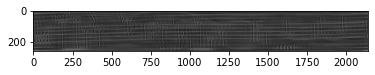

In [195]:
imgrecon = np.real(scipy.fftpack.ifft2(scipy.fftpack.fftshift(seg)))
plt.imshow(imgrecon, cmap='gray')

In [93]:
#white background black content
def find_max_run(arr1, color):
    arr=arr1.astype(int)
    # make sure all runs of ones are well-bounded
    flat = arr.flatten("F")
    if color == 'black':
        #set ends as white
        flat[0]=np.max(flat)
        flat[len(flat)-1]=np.max(flat)
    elif color == 'white':
        flat[0]=np.min(flat)
        flat[len(flat)-1]=np.min(flat)        
    #print(flat)
    # get 1 at run starts and -1 at run ends
    difs = np.diff(flat)
    
    #print(difs)
    #print(np.max(difs))
    #print(np.min(difs))
    run_starts = np.where(difs > 0)[0]
    run_ends = np.where(difs < 0)[0]
    if color == "black":
        runlengths =  run_starts - run_ends
    elif color == 'white':
        runlengths = run_ends-run_starts
    print(runlengths)
    return np.abs(scipy.stats.mode(runlengths)[0][0]), runlengths

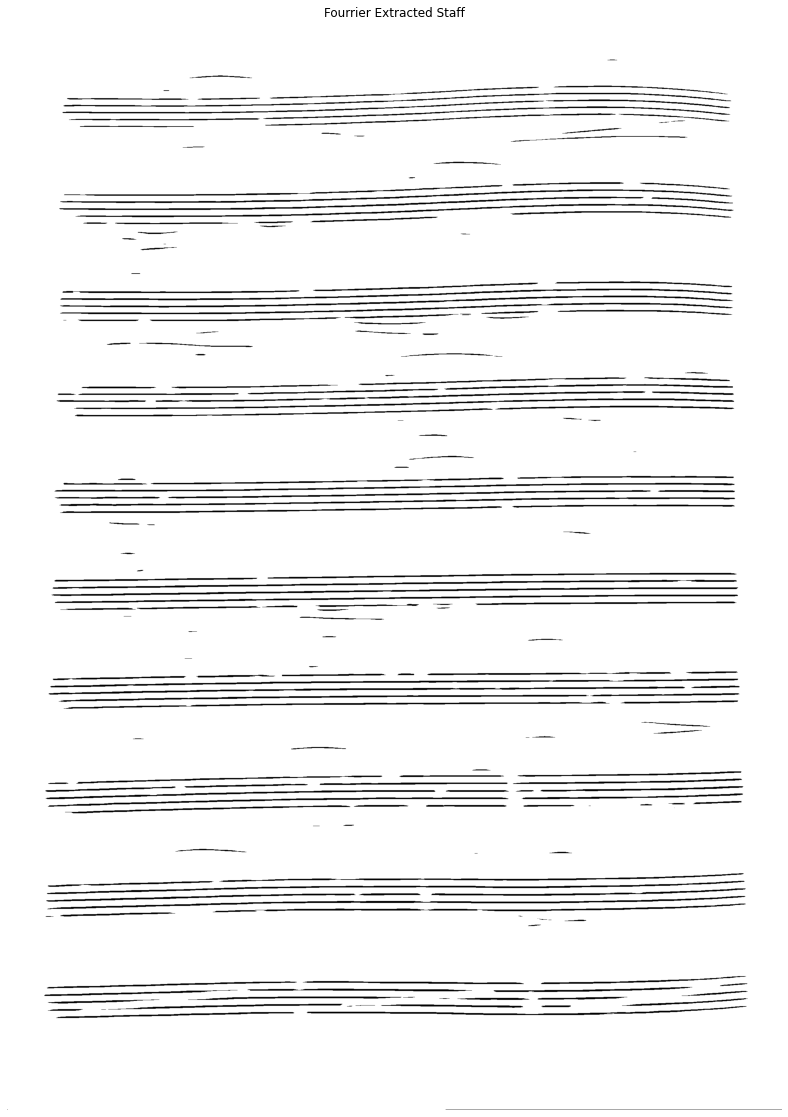

In [94]:
extracted_staff = np.asarray(Image.open("./data/extracted.png"))

plt.figure(figsize=(30, 20))
plt.imshow(extracted_staff, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Fourrier Extracted Staff')

plt.show()

In [95]:
#find onset location (optimize )
def calc_onset(staff):
    forward_onset_total = 0
    backward_onset_total = 0
    i=0
    for rownum in range(0, staff.shape[0]):
        row = staff[rownum, 0:staff.shape[1]-1]
        onsets = np.where(row == 0)
        if len(onsets[0]) != 0:
              
            i+=1
            forward_onset = onsets[0][0]
            forward_onset_total += forward_onset
            
            #calculate back_onset
            
            backward_onset = onsets[0][len(onsets[0])-1]
            #print(onsets)
            #print(backward_onset)
            backward_onset_total += backward_onset
    return forward_onset_total/i , backward_onset_total/i
            
            
            
        

In [96]:
onset = calc_onset(music)

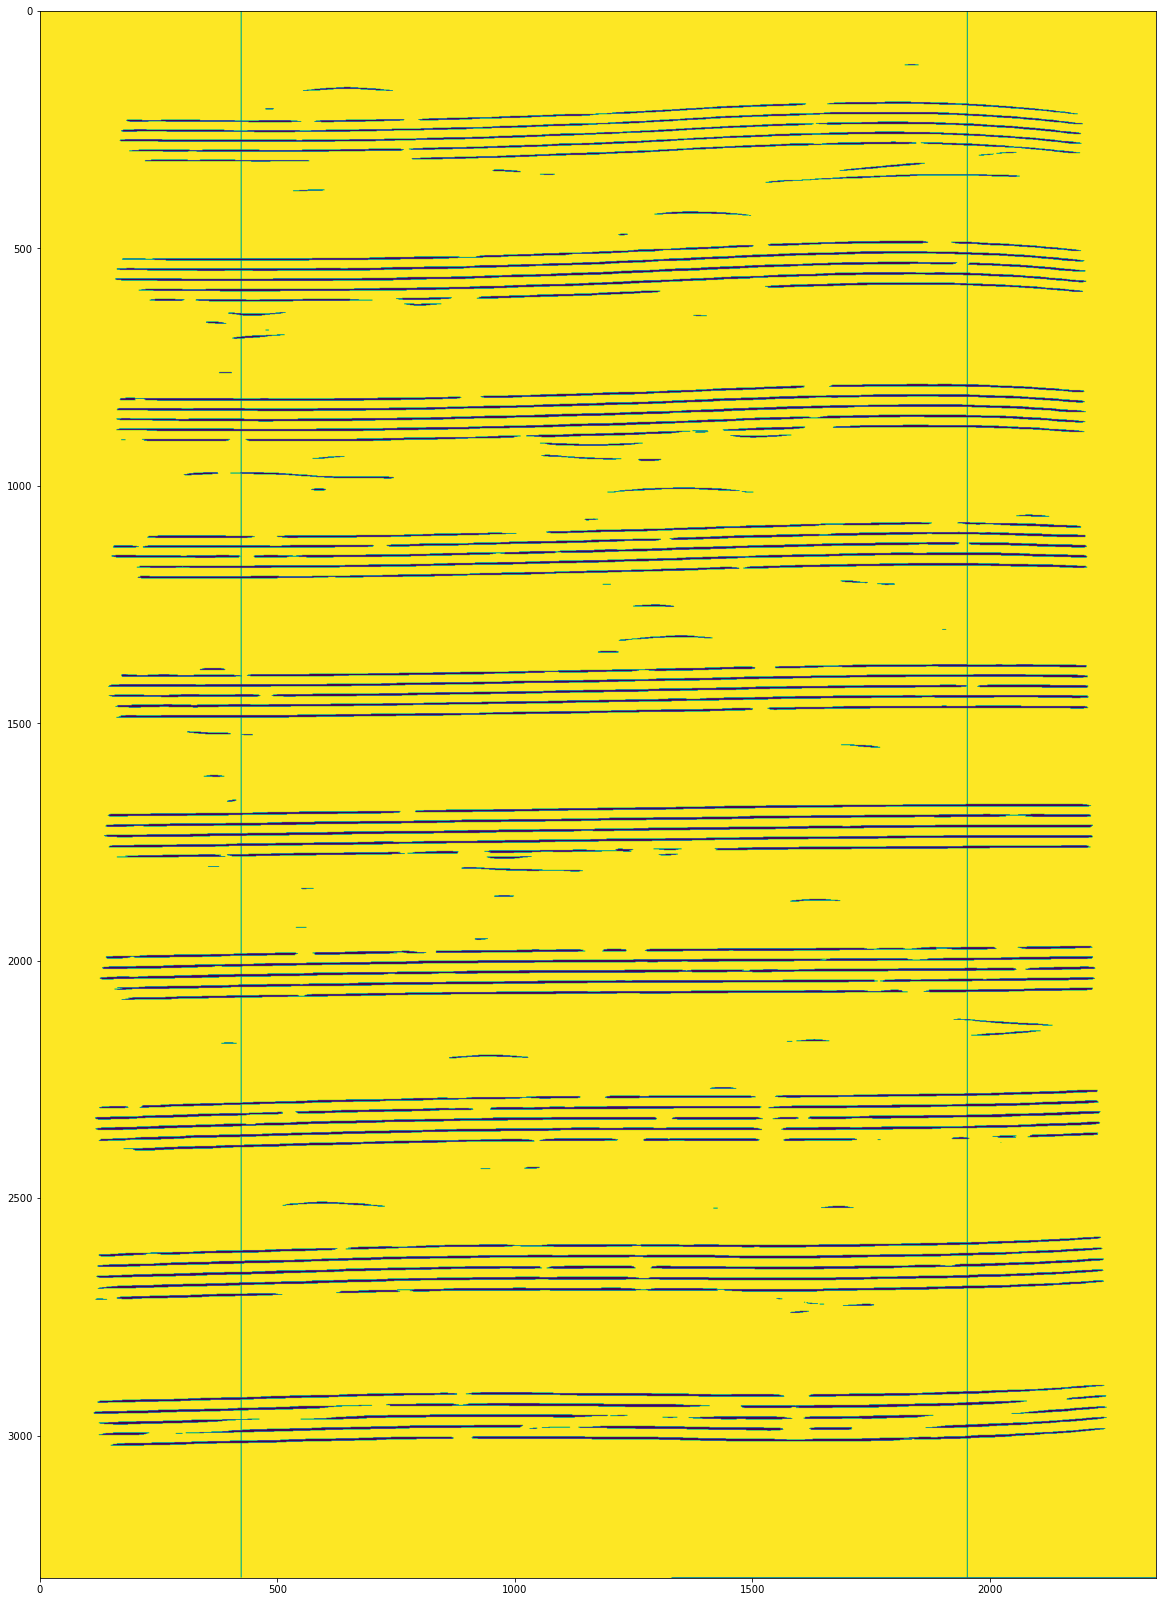

In [97]:
extracted_test = extracted_staff.copy()
extracted_test[0:extracted_test.shape[0]-1, int(onset[0])]=0
extracted_test[0:extracted_test.shape[0]-1, int(onset[1])]=0
plt.figure(figsize=(20,30))
plt.imshow(extracted_test)

In [102]:
def make_blank_img(music):

    staff_iter = 10 # will be caluclated from ccs
    width = int(music.shape[1]*.9)
    #print(width)
    staff_height = find_max_run(music, color="black")[0]
    #print(staff_height)
    space_height = find_max_run(music, color= "white")[0]
    #print(space_height)
    staff_space = np.ones((staff_height+space_height, width))*np.max(music)
    staff_space[0:staff_height]=0
    staff = np.tile(staff_space, (5,1))
    staff_chunk = np.ones((int(staff.shape[0]*2.6), width))*np.max(music)
    staff_chunk[0: staff.shape[0], 0:staff.shape[1]]=staff
    staff_core = np.tile(staff_chunk, (10,1))
    blank_img = np.ones(music.shape)*np.max(music)
    
    x_offset = int((blank_img.shape[0] - staff_core.shape[0])/2)
    y_offset = int((blank_img.shape[1] - staff_core.shape[1])/2)
    print(x_offset)
    blank_img[x_offset:x_offset+staff_core.shape[0], \
              y_offset:y_offset+staff_core.shape[1]] = staff_core
    
    return blank_img
    
    
    
    
    
                    
    


[   1    1    1 ...    6    3 3330]
[3298 3299 3299 ...  159 1841   12]
220


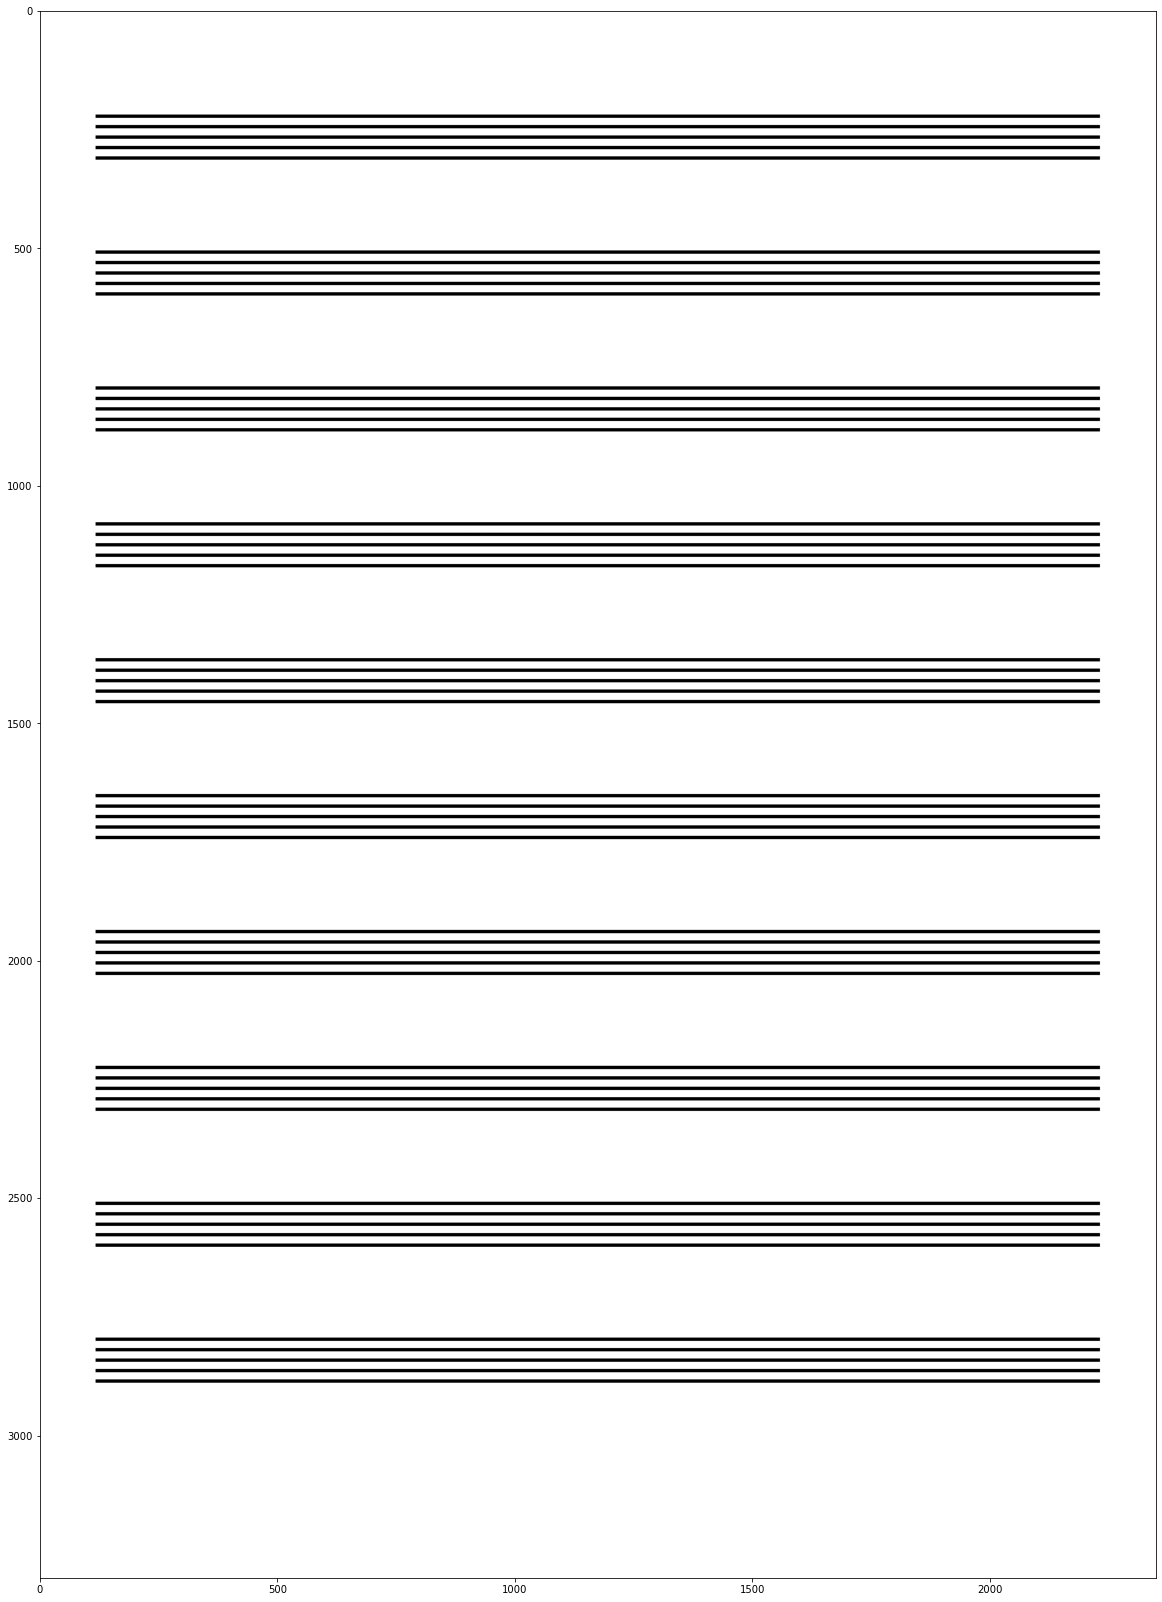

In [103]:
blank_img = make_blank_img(music)
plt.figure(figsize=(20,30))
plt.imshow(blank_img, cmap='gray')

# Full Music Deformation with Affine Registered Image

In [104]:
'''
Optimizing two properties: 
1-scale_rows, 
2-shift_row, 
3 -shift_col
4 - scale_cols
5 - theta
'''


def f(x, ref_img, comp_img):
    scale_row=x[0]
    shift_row =x[1]
    shift_col=x[2]
    scale_col = x[3]

    
 
    
    scale_translation_matrix = np.array([[scale_row, 0,         shift_row],
                                   [0,         scale_col, shift_col],
                                   [0,         0,         1       ]])   
 

    comp_img1 = affine_transform(comp_img, scale_translation_matrix)
    
    ssd = np.sum((comp_img1 - ref_img) ** 2)
    print(ssd)

    
    return ssd


In [105]:
'''
Optimizing two properties: 
1-scale_rows, 
2-shift_row, 
3 -shift_col
4 - scale_cols
5 - theta
'''


def f_output(x, ref_img, comp_img):
    scale_row=x[0]
    shift_row =x[1]
    shift_col=x[2]
    scale_col = x[3]

    
 
    
    scale_translation_matrix = np.array([[scale_row, 0,         shift_row],
                                   [0,         scale_col, shift_col],
                                   [0,         0,         1       ]])   
 

    comp_img1 = affine_transform(comp_img, scale_translation_matrix)
    
    ssd = np.sum((comp_img1 - ref_img) ** 2)
    print(ssd)
    plt.figure(figsize=(20,30))
    plt.imshow(comp_img1+ref_img)
    
    return comp_img1, comp_img1+ref_img


In [36]:
'''
x[0] is theta
x[1] is row shift
x[2] is col shift
'''


def f2(x, comp_img, comp_center):
    theta = x[0]
    
    rotation_matrix = np.array([[np.cos(theta), -1*np.sin(theta)],  
                                [np.sin(theta), np.cos(theta)]])
    #print("comp center is ", comp_center)
    #print("rotation matrix is ", rotation_matrix)
    comp_center = list(ndimage.center_of_mass(comp_img1))
    ref_center = list(ndimage.center_of_mass(ref_img))
    new_center_estimate = np.dot(rotation_matrix, comp_center)
    #print("new center estimate is ", new_center_estimate)
    back_shift = new_center_estimate - ref_center
    #print("back_shift is ", back_shift)    
    rotation_translation_matrix = np.array(([[np.cos(theta), -1*np.sin(theta),  -back_shift[0]],  
                                                 [np.sin(theta), np.cos(theta), -back_shift[1]],
                                                 [0 ,     0,         1]]))
        
        
    #print("rotation_translation_matrix", rotation_translation_matrix)    
    '''
    Apply rotation_translation_matrix
    '''
    comp_img1 = affine_transform(comp_img, rotation_translation_matrix)
        
    ssd = np.sum((comp_img1 - ref_img) ** 2)
    #print("x is ", x)
    #print("ssd is ", ssd)
 
    
    return ssd

    

In [37]:

'''
x[0] is theta

'''


def f2_output(x, comp_img, comp_center):
    theta = x[0]
    
    rotation_matrix = np.array([[np.cos(theta), -1*np.sin(theta)],  
                                [np.sin(theta), np.cos(theta)]])
    #print("comp center is ", comp_center)
    #print("rotation matrix is ", rotation_matrix)
    comp_center = list(ndimage.center_of_mass(comp_img1))
    ref_center = list(ndimage.center_of_mass(ref_img))
    new_center_estimate = np.dot(rotation_matrix, comp_center)
    #print("new center estimate is ", new_center_estimate)
    back_shift = new_center_estimate - ref_center
    #print("back_shift is ", back_shift)    
    rotation_translation_matrix = np.array(([[np.cos(theta), -1*np.sin(theta),  -back_shift[0]],  
                                                 [np.sin(theta), np.cos(theta), -back_shift[1]],
                                                 [0 ,     0,         1]]))
        
        
    #print("rotation_translation_matrix", rotation_translation_matrix)    
    '''
    Apply rotation_translation_matrix
    '''
    comp_img1 = affine_transform(comp_img, rotation_translation_matrix)
        
    ssd = np.sum((comp_img1 - ref_img) ** 2)
  
    
    plt.figure(figsize=(20,30))
    plt.imshow(comp_img1+ref_img)
    
    return comp_img2, comp_img1+ref_img


31909302


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

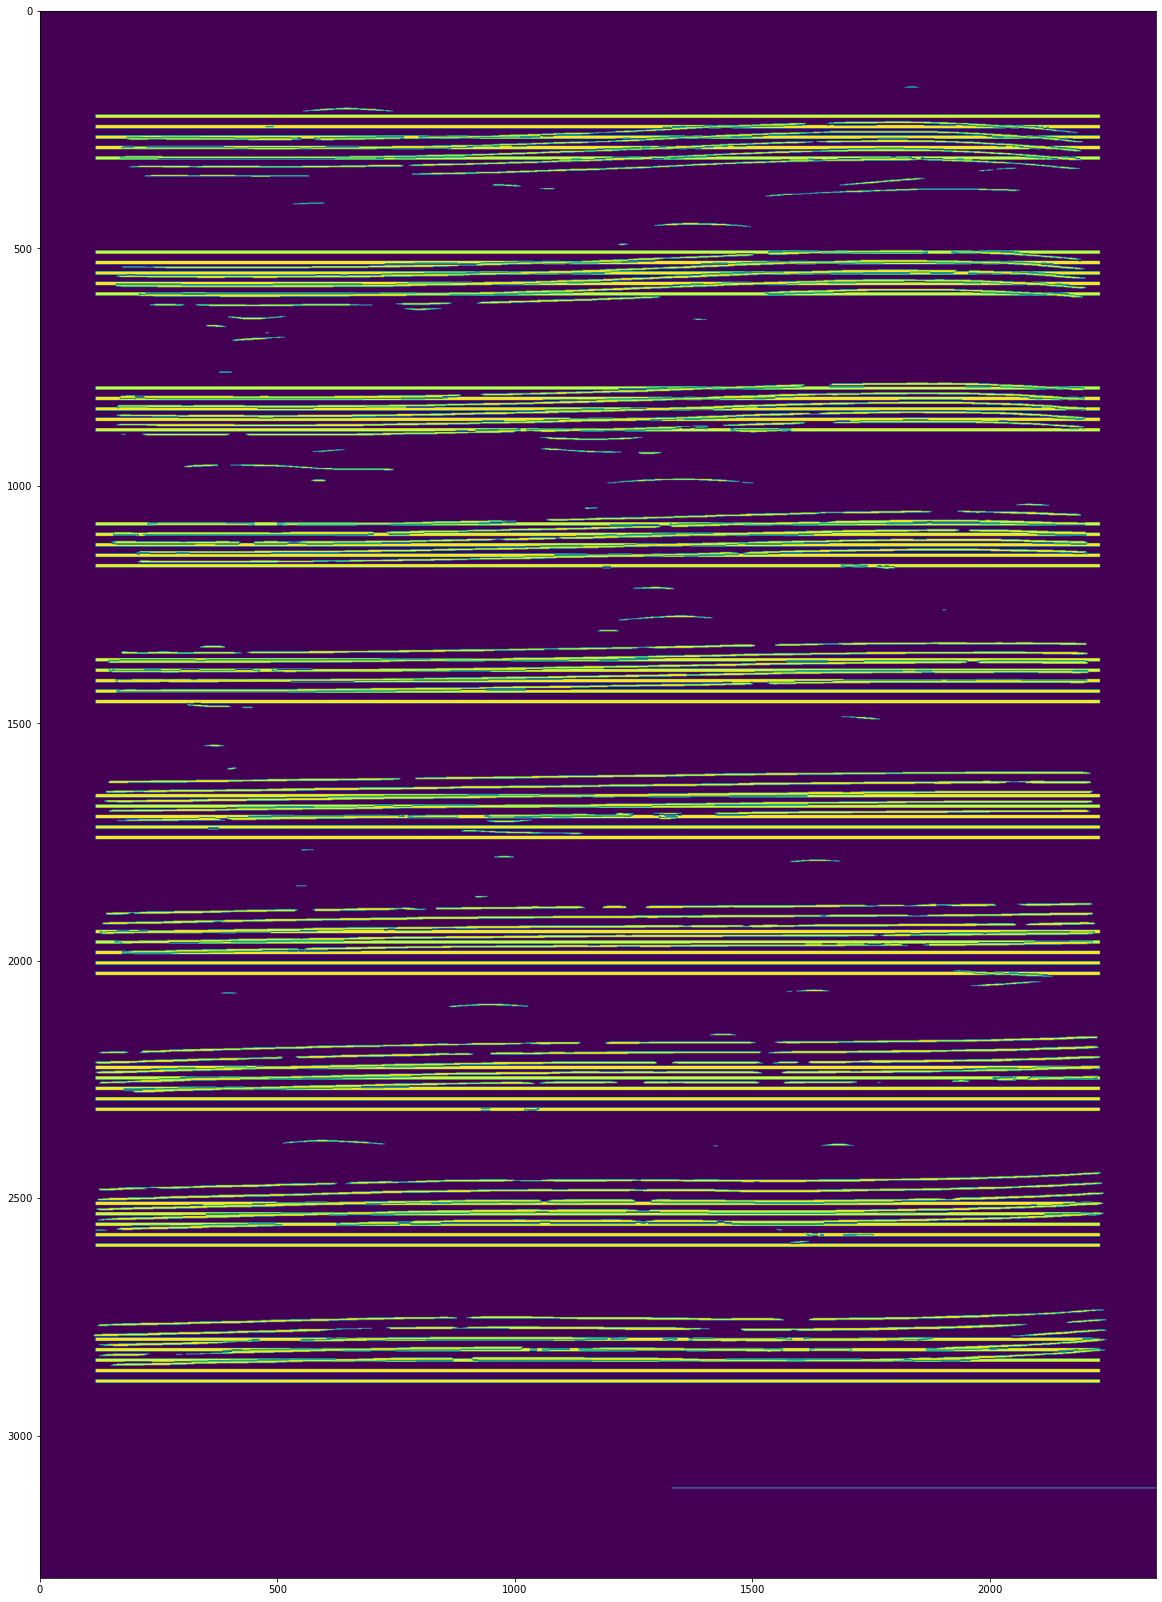

In [108]:
x=[1.08, -60, 0, 1, .01]
f_output(x, ~blank_img.astype(np.uint8), ~extracted_staff.astype(np.uint8))

In [202]:
'''
Use Powell's method to optimize
'''
a = optimize.minimize(f, [1,0,0,1], args = (blank_img, extracted_staff), method='Powell', tol=30000000)
                                                                                                             
                                                                                                        
                                                                                                            
       

64142675775.0
64142675775.0
262443370950.0
455981310000.0
64142675775.0
67541357949.0
183095046276.0
68304828632.0
128582465935.0
68398208559.0
89923102984.0
70706074159.0
67736408693.0
67005401025.0
64432165992.0
63927383876.0
63927383876.0
64560972600.0
63634302666.0
63570706801.0
63570706801.0
63570706801.0
63784143841.0
63965917164.0
63570706801.0
63751081704.0
63750453894.0
63782866492.0
63779936462.0
63784055047.0
63784614180.0
63784661857.0
63784832213.0
63784732498.0
63784808059.0
63784755718.0
63784790710.0
63784759970.0
63784771840.0
63784772270.0
63784771504.0
63784775099.0
63784767483.0
63784767458.0
63784767957.0
63784766776.0
63784765990.0
63784767967.0
63784767262.0
63784768530.0
63784768326.0
63784768665.0
63784768806.0
63784768705.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63784769101.0
63

In [198]:
'''
Use ’L-BFGS-B’ method to optimize
'''
a = optimize.minimize(f, [1 , 0 , 0 , 1 , 0], \
    args = (~blank_img.astype(np.uint8), ~music.astype(np.uint8)), method='L-BFGS-B',\
                      bounds =[(.8, 1.2), (-100, 100), (-100,100), (.9, 1.1), (0,0) ])
                                                                                                             
                                                                                                        
                                                                                                            
       

1453156
1450806


/opt/anaconda3/envs/transposition-env/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: overflow encountered in ulong_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


1450806
1449856
1449856
1453156
51234503
51248856
51234531
51234477
51235078
51234503
54795109
54792486
54795109
54795109
54795585
54795109
52063558
52046185
52063558
52063558
52061490
52063558
52147381
52150700
52147381
52147381
52145423
52147381
52157637
52157577
52157637
52157637
52157786
52157637
51260646
51260439
51260646
51260646
51259774
51260646
58518548
58510999
58518548
58518725
58519590
58518548
44356184
44362050
44356184
44356281
44354972
44356184
26230279
26223210
26230268
26230279
26229800
26230279
3922820
3919284
3922820
3922817
3921961
3922820
1757138
1755056
1757138
1757138
1757086
1757138
1453262
1453236
1453262
1453262
1453244
1453262
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1453153
1450804
1453153
1453153
1449854
1453153
1453153
1450804
1453153
1453153
1449854
1453153
1453153
1450804
1453153
1453153
1449854
1453153
1453153
1450804
1453153
1453153
1449854
1453153
14

In [197]:
a

      fun: 1453156
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 0
   status: 0
  success: True
        x: array([1., 0., 0., 1., 0.])

In [201]:
a.x

array([1., 0., 0., 1., 0.])

986431


(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [  0,   0, 255, ...,   0,   0,   0]], dtype=uint8),
 array([[254, 254, 254, ..., 254, 254, 254],
        [254, 254, 254, ..., 254, 254, 254],
        [254, 254, 254, ..., 254, 254, 254],
        ...,
        [254, 254, 254, ..., 254, 254, 254],
        [254, 254, 254, ..., 254, 254, 254],
        [255, 255, 254, ..., 255, 255, 255]], dtype=uint8))

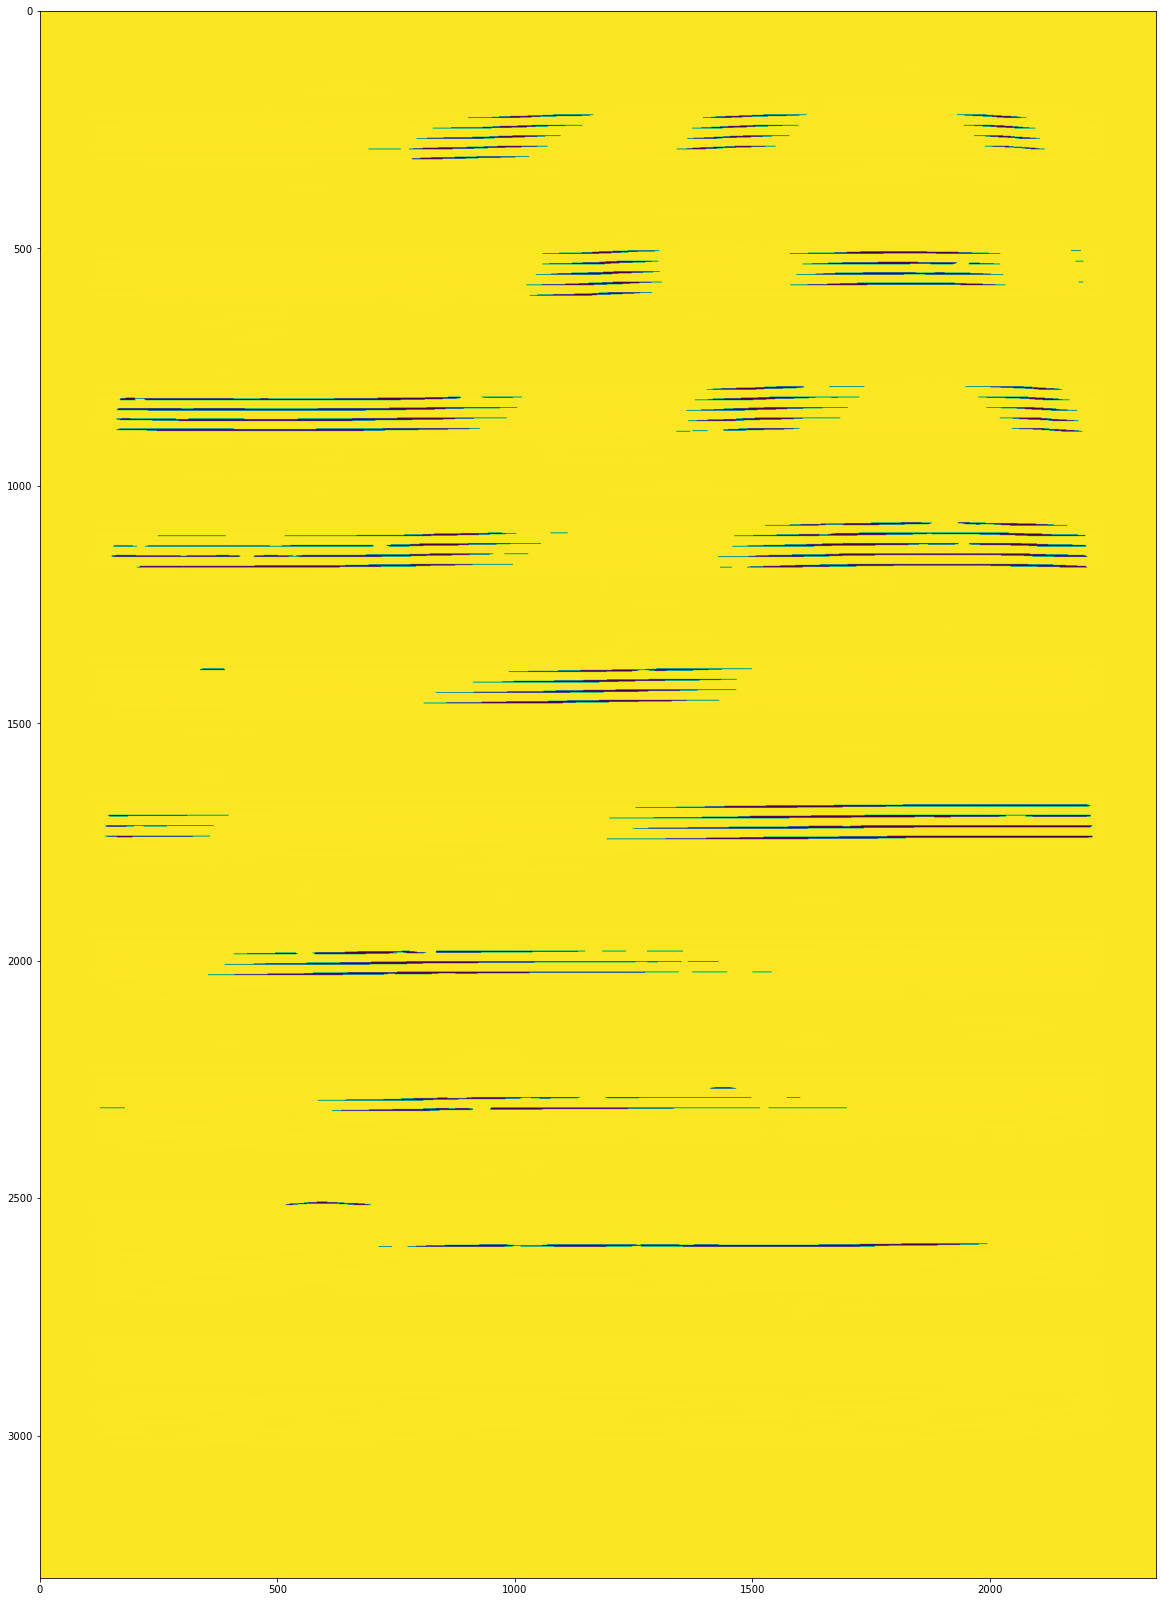

In [200]:
x=[1.08, -60, 0, 1, .01]
f_output(a.x, blank_img.astype(np.uint8), extracted_staff.astype(np.uint8))

Nonrigid Deformation

In [205]:
moving = ~extracted_staff
static = ~(blank_img.astype(np.uint8))

In [206]:
dim = static.ndim
metric = SSDMetric(dim)
level_iters = [100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=20, opt_tol =1e-01)



In [207]:
mapping = sdr.optimize(static, moving)

In [126]:
SymmetricDiffeomorphicRegistration?
